In [1]:
# pull data from polygon
import datetime
import numpy as np
from scipy.signal import detrend
import requests


In [2]:
import numpy as np
from pycwt import wct
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.io.wavfile as wav
import fcwt
# Compute the wavelet coherence
def wavelet_coherence(signal1,signal2,highest,lowest,nfreqs,frame_rate):
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,lowest,highest,nfreqs,nthreads = 4,)
    freqs, coeffs2 = fcwt.cwt(signal2,frame_rate,lowest,highest,nfreqs,nthreads = 4,)

    # Compute coherence
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)
    
    # Smooth spectra and cross-spectrum
    def smooth(data, sigma=(2,2), mode='nearest'):
        #return data
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smoothed = smooth(S1)
    S2_smoothed = smooth(S2)
    S12_smoothed = smooth(np.abs(S12) ** 2)

    # Coherence calculation
    coherence = S12_smoothed / (((S1_smoothed) **2) * ((S2_smoothed)**2))
    coherence = S12_smoothed / (np.sqrt(S1_smoothed) * np.sqrt(S2_smoothed))
    #coherence = np.clip(coherence, 0.0, 1.0)  # Limit coherence to [0, 1]

    return coherence, freqs, [coeffs1,coeffs2], S12

lowest = 2 # days
highest = 100 # days

#coherence, freqs, coeffs, S12 = wavelet_coherence(detrended, detrended2, 1/lowest, 1/highest, 100, 1)

In [84]:
def coherence_plot_with_arrows(coherence, freqs, S12,density = 20):
    extent = [0, coherence.shape[1], len(freqs), 0]

    # Normalize coherence for color map
    #coherence = np.clip(coherence, 0, 3)
    norm_coh = (coherence - coherence.min()) / (coherence.max() - coherence.min())

    # Phase angle and vectors
    phase = np.angle(S12)
    U = np.cos(phase)
    V = np.sin(phase)

    # Coordinate grid
    X, Y = np.meshgrid(np.arange(coherence.shape[1]), np.arange(coherence.shape[0]))

    # Mask: only take high-coherence regions
    mask = norm_coh > .2
    indices = np.argwhere(mask)

    # Subsample: take every nth index from the masked points
    subsample_rate = extent[1] // density  # Adjust this value to control the number of arrows
    subsampled_indices = indices[::subsample_rate]

    x_sub = [X[i, j] for i, j in subsampled_indices]
    y_sub = [Y[i, j] for i, j in subsampled_indices]
    u_sub = [U[i, j] for i, j in subsampled_indices]
    v_sub = [V[i, j] for i, j in subsampled_indices]

    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))

    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    extent=[0, coherence.shape[1], len(freqs),0]

    # Plot coherence
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(norm_coh, aspect='auto', extent=extent, cmap='Reds')
    ax.quiver(x_sub, y_sub, u_sub, v_sub, color='black', scale=30, headwidth=3
              , headlength=5, headaxislength=4)

    dt = 1 / 200


    # Axes labels and ticks
    ax.set_yticks(subsampled_indices)
    ax.set_yticklabels(subsampled_y_values.round(2))
    ax.set_xticks(np.linspace(0, coherence.shape[1], 5))
    ax.set_ylabel('Frequency (Per Year)', fontsize=14)
    ax.set_xlabel('Time (Days)', fontsize=14)
    #ax.set_title('Wavelet Coherence', fontsize=16)
    fig.colorbar(im, ax=ax)
    #ax.legend()

    return fig



In [29]:
import mne
epochs = mne.io.read_epochs_eeglab('syn02-s253-clean.set',verbose = True)

Extracting parameters from c:\Users\E7450\Documents\MSResearch\Wavelet-Tech\EEG\syn02-s253-clean.set...


C:\Users\E7450\AppData\Local\Temp\ipykernel_22876\2897685776.py:2: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab('syn02-s253-clean.set',verbose = True)


Not setting metadata
231 matching events found
No baseline correction applied
0 projection items activated
Ready.


In [30]:
# Extract the data (shape: n_epochs × n_channels × n_times)
data = raw.get_data()

# Concatenate over time axis (2) across all epochs
# This will give a 2D array: n_channels × total_timepoints
continuous_data = data.transpose(1, 0, 2).reshape(data.shape[1], -1)
continuous_data.shape
ch_names = epochs.ch_names
sfreq = epochs.info['sfreq']

Creating RawArray with float64 data, n_channels=61, n_times=189420
    Range : 0 ... 189419 =      0.000 ...   947.095 secs
Ready.


Using matplotlib as 2D backend.


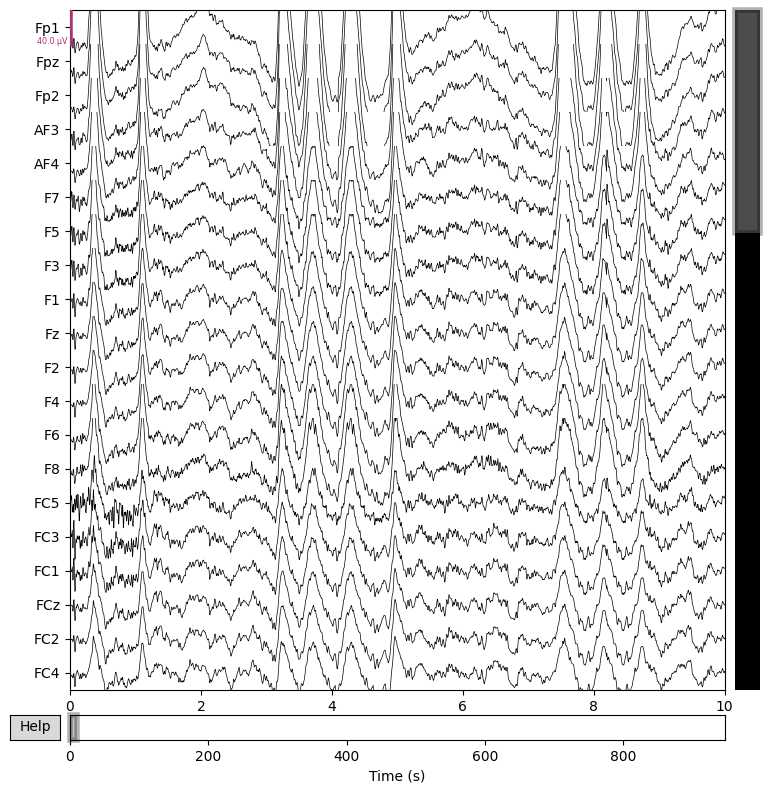

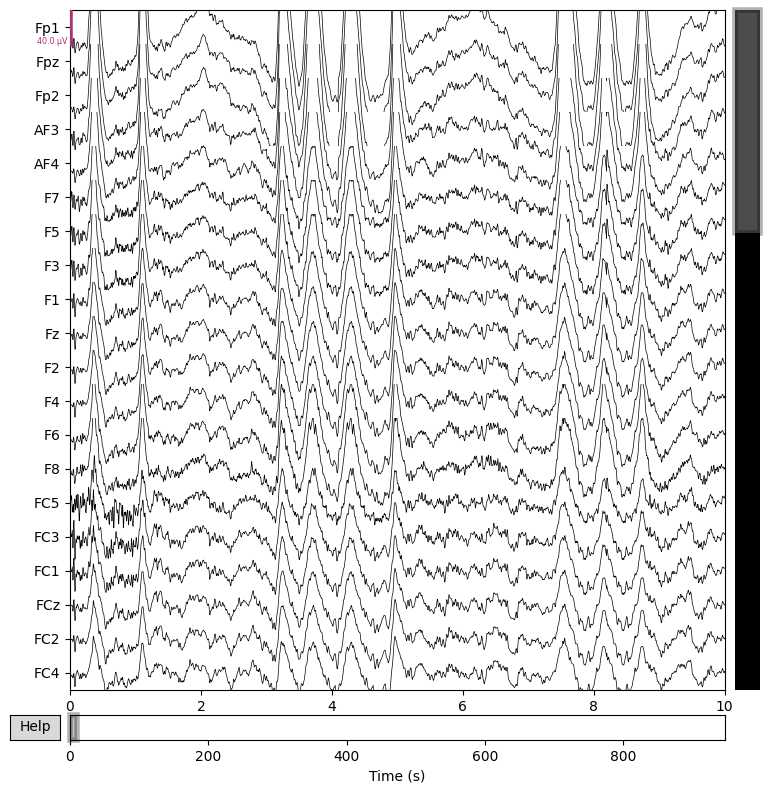

In [31]:
from mne import create_info
from mne.io import RawArray


info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
raw1 = RawArray(continuous_data, info)
raw1.plot()

In [63]:


# --- WAVELET COHERENCE FUNCTION ---
def wavelet_coherence(signal1, signal2, highest_freq, lowest_freq, nfreqs, sampling_rate):
    freqs, coeffs1 = fcwt.cwt(signal1, sampling_rate, lowest_freq, highest_freq, nfreqs, nthreads=4,scaling='log')
    _, coeffs2 = fcwt.cwt(signal2, sampling_rate, lowest_freq, highest_freq, nfreqs, nthreads=4,scaling='log')
    
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)

    def smooth(data, sigma=(2, 2), mode='nearest'):
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smooth = smooth(S1)
    S2_smooth = smooth(S2)
    S12_smooth = smooth(np.abs(S12) ** 2)

    coherence = S12_smooth / (np.sqrt(S1_smooth) * np.sqrt(S2_smooth))
    return coherence, freqs

def coherence(coeffs1, coeffs2, freqs):
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)

    def smooth(data, sigma=(2, 2), mode='nearest'):
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smooth = smooth(S1)
    S2_smooth = smooth(S2)
    S12_smooth = smooth(np.abs(S12) ** 2)

    coh = S12_smooth / (np.sqrt(S1_smooth) * np.sqrt(S2_smooth))
    return coh, freqs, S12


In [79]:
def transform(signal1,frame_rate,highest,lowest):
    nfreqs = 100
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,lowest,highest,nfreqs,nthreads = 4,scaling='log')

    return coeffs1,freqs

def transform_plot(signal,frame_rate,highest,lowest):


    coeffs1,freqs = transform(signal,frame_rate,highest,lowest)

    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    extent=[0, len(signal)/frame_rate, len(freqs),0]
    plt.figure(figsize=(10, 5));
    plt.imshow(np.abs(coeffs1), aspect='auto', extent=extent, cmap='Accent')
    plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Magnitude')
    cbar.set_ticks([])  
    plt.xlabel('Time (S)')
    plt.ylabel('Frequency (Hz)')
    #plt.title('Wavelet Transform Magnitude')
    plt.tight_layout()
    plt.show()
    return coeffs1,freqs

#transform_plot(detrended2,250,125,3)

In [76]:
import mne
import numpy as np

# Define the channels you want
ch_names = ["Fz", "Pz"]

# Ensure those channels exist
picks = mne.pick_channels(epochs.info["ch_names"], include=ch_names)

# Get sampling frequency and number of time points per epoch
sfreq = epochs.info['sfreq']
samples_needed = int(60 * sfreq)

# Concatenate data from all epochs
data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
full_data = data.transpose(1, 0, 2).reshape(data.shape[1], -1)  # shape: (n_channels, total_time)

# Slice the first 10 seconds from the selected channels
selected_data = full_data[picks, :samples_needed]  # shape: (2, samples_needed)

# Save each channel as a separate NumPy array
np.save("Fz_10sec.npy", selected_data[0])
np.save("Pz_10sec.npy", selected_data[1])


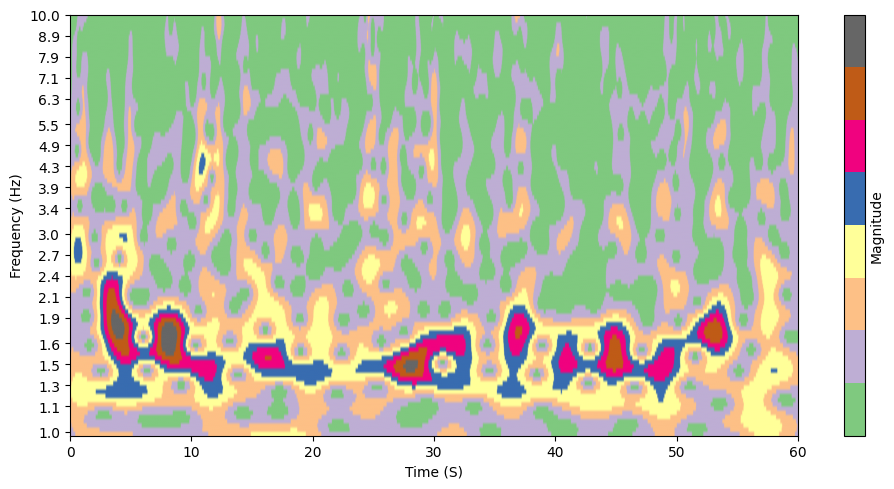

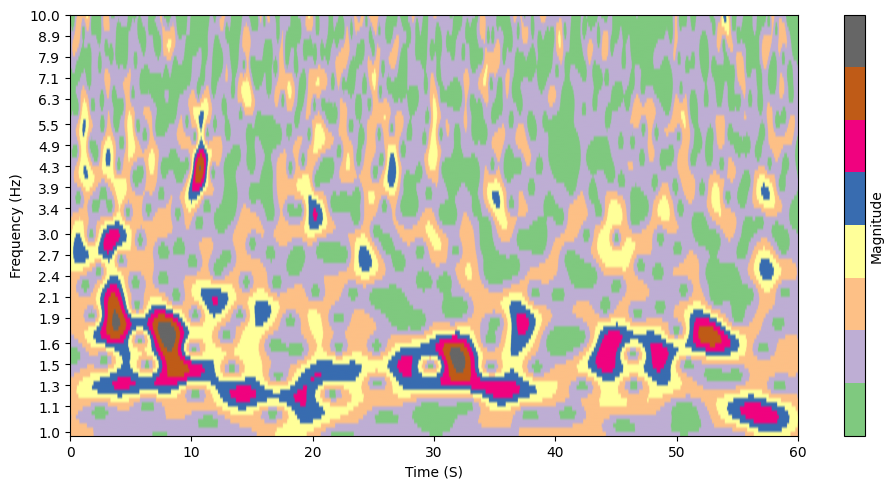

In [80]:
coeffs1,freqs = transform_plot(selected_data[0],int(sfreq),10,1)
coeffs2,_ = transform_plot(selected_data[1],int(sfreq),10,1)

In [92]:
def coherence_plot_with_arrows(coherence, freqs, S12,density = 20):
    extent = [0, coherence.shape[1], len(freqs), 0]

    # Normalize coherence for color map
    #coherence = np.clip(coherence, 0, 3)
    norm_coh = (coherence - coherence.min()) / (coherence.max() - coherence.min())

    # Phase angle and vectors
    phase = np.angle(S12)
    U = np.cos(phase)
    V = np.sin(phase)

    # Coordinate grid
    X, Y = np.meshgrid(np.arange(coherence.shape[1]), np.arange(coherence.shape[0]))

    # Mask: only take high-coherence regions
    mask = norm_coh > .2
    indices = np.argwhere(mask)

    # Subsample: take every nth index from the masked points
    subsample_rate = extent[1] // density  # Adjust this value to control the number of arrows
    subsampled_indices = indices[::subsample_rate]

    x_sub = [X[i, j] for i, j in subsampled_indices]
    y_sub = [Y[i, j] for i, j in subsampled_indices]
    u_sub = [U[i, j] for i, j in subsampled_indices]
    v_sub = [V[i, j] for i, j in subsampled_indices]

    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))

    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    extent=[0, coherence.shape[1], len(freqs),0]

    # Plot coherence
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(norm_coh, aspect='auto', extent=extent, cmap='Reds')
    ax.quiver(x_sub, y_sub, u_sub, v_sub, color='black', scale=30, headwidth=3
              , headlength=5, headaxislength=4)

    dt = 1 / 200


    # Axes labels and ticks
    ax.set_yticks(subsampled_indices)
    ax.set_yticklabels(subsampled_y_values.round(2))
    ax.set_xticks(np.linspace(0, coherence.shape[1], 5),labels = np.linspace(0, coherence.shape[1]/200, 5))
    ax.set_ylabel('Frequency (Hz)', fontsize=14)
    ax.set_xlabel('Time (S)', fontsize=14)
    #ax.set_title('Wavelet Coherence', fontsize=16)
    fig.colorbar(im, ax=ax)
    #ax.legend()

    return fig



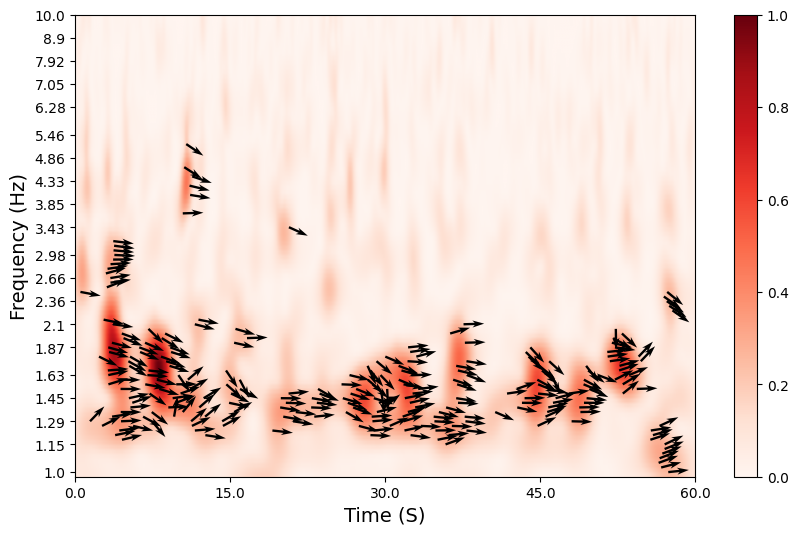

In [93]:
coh,freqs,S12 = coherence(coeffs1,coeffs2,freqs)
coherence_plot_with_arrows(coh, freqs,S12,density = 20);


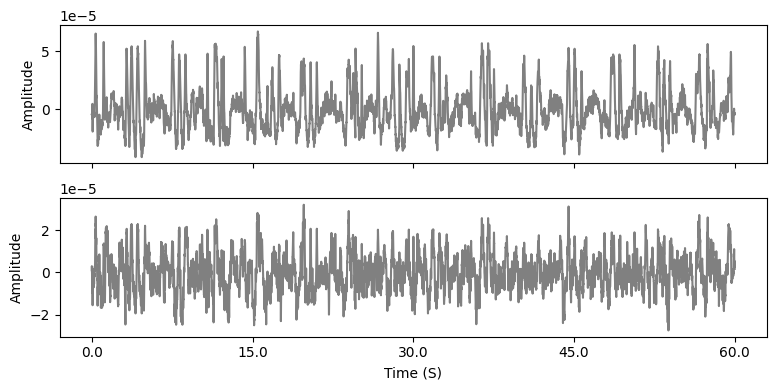

In [102]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# Plot selected_data[0]
axs[0].plot(selected_data[0], color='grey')
#axs[0].set_title('Selected Data [0]')
axs[0].set_ylabel('Amplitude')

# Plot selected_data[1]
axs[1].plot(selected_data[1], color='grey')
#axs[1].set_title('Selected Data [1]')
axs[1].set_xlabel('Time (S)')
axs[1].set_ylabel('Amplitude')
axs[1].set_xticks(np.linspace(0, samples_needed, 5), labels=np.linspace(0, 60, 5))

# Adjust layout
plt.tight_layout()
plt.show()

In [53]:
def coherence_plot(coh,freqs,sampling_rate):
    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))

    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    extent=[0, coh.shape[1]/sampling_rate, len(freqs),0]
    plt.figure(figsize=(10, 5));
    plt.imshow(coh, aspect='auto', extent=extent, cmap='Blues')
    plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])

    plt.colorbar(label='Coherence')
    plt.xlabel('Time (years)')
    plt.ylabel('Frequency (per year)')
    plt.title('Wavelet Coherence')
    plt.tight_layout()
    plt.show()

def workflow(sig1,sig2,bounds,phase = True):
    sampling_rate = 250 # Assuming days per year
    highest = bounds[0]
    lowest = bounds[1]
    t1,_ = transform(sig1, 250, highest, lowest)
    t2,freqs = transform(sig2, 250, highest, lowest)
    coh, _, S12 = coherence(t1, t2, freqs)
    if phase:
        coherence_plot_with_arrows(coh, freqs, S12)
    else:
        coherence_plot(coh, freqs, 250)
    return freqs,S12,coh


#sig1 = pull_data('TSLA', key)[2]  # Detrended signal for AAPL
#sig2 = pull_data('MSTR', key)[2]  # Detrended signal for AMZN
#bounds = (125, 8)  # Example bounds for the wavelet transform
#freqs,S12,coh = workflow(sig1,sig2,bounds)

In [54]:
import numpy as np

def generate_nonstationary_signal(duration, sampling_rate, freq_range):
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    signal = np.zeros_like(t)

    # Embed frequencies within the specified range
    for freq in np.linspace(freq_range[0], freq_range[1], num=5):  # 5 frequencies
        amplitude = np.random.uniform(0.5, 1.5)  # Random amplitude
        phase = np.random.uniform(0, 2 * np.pi)  # Random phase
        modulation = np.exp(-0.5 * ((t - duration / 2) / (duration / 4))**2)  # Gaussian envelope
        signal += amplitude * modulation * np.sin(2 * np.pi * freq * t + phase)

    # Add random noise
    signal += 0.2 * np.random.randn(len(t))
    return t, signal

# Parameters
duration = 10  # seconds
sampling_rate = 250  # Hz
freq_range = (10, 100)  # Hz

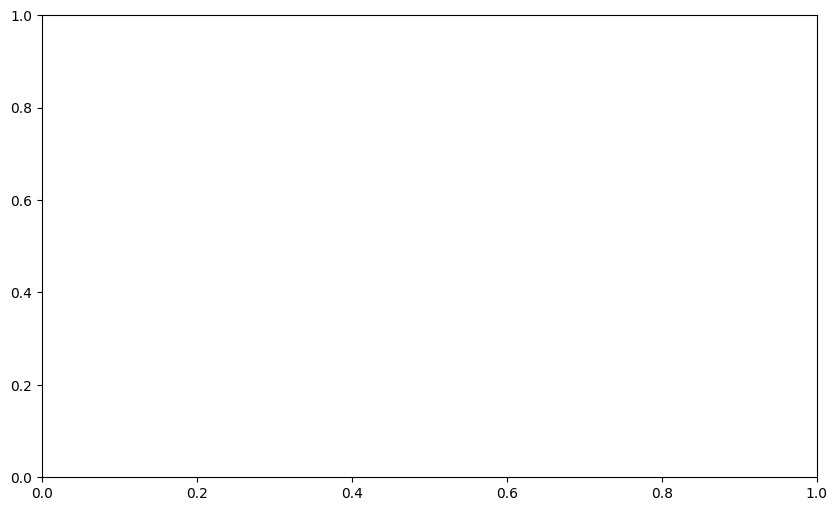

In [112]:
# filename: wavelet_dashboard.ipynb

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Your functions: transform, coherence, coherence_plot, coherence_plot_with_arrows, pull_data

def workflow(sig1, sig2, bounds, phase=True,density = 20):
    sampling_rate = 250  # days/year
    highest, lowest = bounds
    t1, _ = transform(sig1, sampling_rate, highest, lowest)
    t2, freqs = transform(sig2, sampling_rate, highest, lowest)
    coh, _, S12 = coherence(t1, t2, freqs)
    
    #fig = plt.figure(figsize=(10, 6));
    if phase:
        coherence_plot_with_arrows(coh, freqs, S12,density)
    else:
        coherence_plot(coh, freqs, sampling_rate)
    plt.show()

    return freqs, S12, coh

# --- Widgets ---
ticker1 = widgets.Text( description='Stock 1:')
ticker2 = widgets.Text( description='Stock 2:')
upper_bound = widgets.IntSlider(value=125, min=20, max=250, step=5, description='Max Period:')
lower_bound = widgets.IntSlider(value=8, min=2, max=50, step=1, description='Min Period:')
phase_toggle = widgets.Checkbox(value=True, description='Show Phase Arrows')
run_button = widgets.Button(description='Run Analysis')

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

output = widgets.Output()

def on_run_clicked(b):
    with output:
        clear_output(wait=True)
        sig1 = pull_data(ticker1.value, key)[2]
        sig2 = pull_data(ticker2.value, key)[2]
        bounds = (upper_bound.value, lower_bound.value)
        workflow(sig1, sig2, bounds, phase=phase_toggle.value,density = 20)

run_button.on_click(on_run_clicked)

# Layout
ui = widgets.VBox([
    widgets.HBox([ticker1, ticker2]),
    upper_bound,
    lower_bound,
    phase_toggle,
    run_button,
    output
])

display(ui)


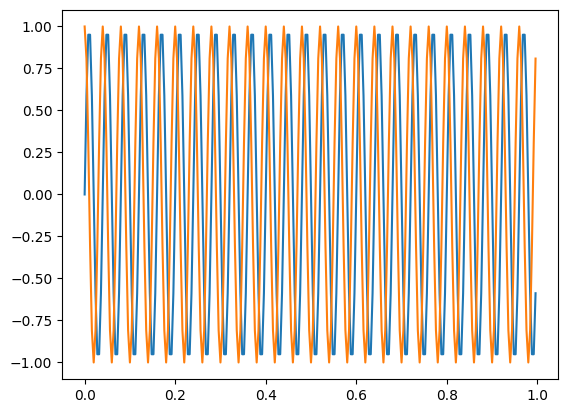

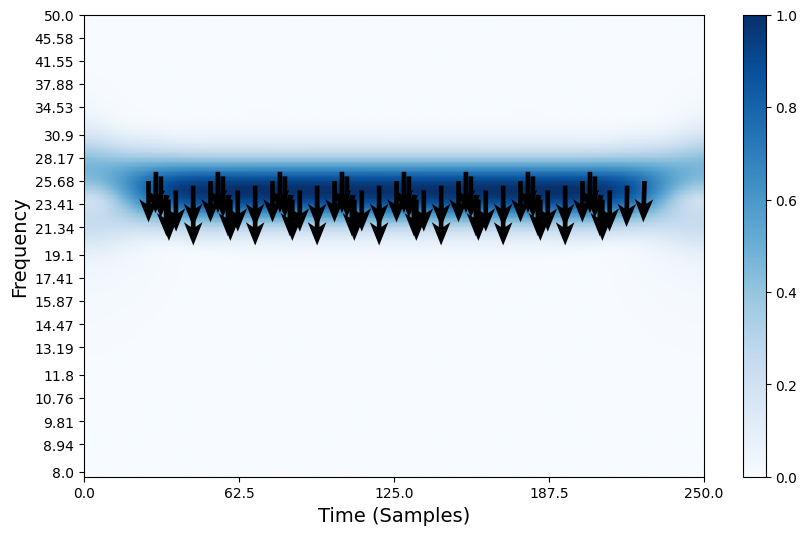

(array([50.000004 , 49.082977 , 48.18276  , 47.299057 , 46.431557 ,
        45.579975 , 44.744007 , 43.923378 , 43.11779  , 42.326984 ,
        41.550674 , 40.788612 , 40.04052  , 39.306152 , 38.58525  ,
        37.877575 , 37.182873 , 36.500916 , 35.831463 , 35.174294 ,
        34.52917  , 33.895885 , 33.27421  , 32.663944 , 32.06486  ,
        31.476776 , 30.899467 , 30.332754 , 29.776428 , 29.230314 ,
        28.694208 , 28.16794  , 27.651318 , 27.144178 , 26.646332 ,
        26.157625 , 25.677874 , 25.206926 , 24.744617 , 24.290783 ,
        23.845272 , 23.407936 , 22.978622 , 22.557177 , 22.143461 ,
        21.737339 , 21.338663 , 20.947296 , 20.563107 , 20.185968 ,
        19.815744 , 19.45231  , 19.095541 , 18.745317 , 18.401518 ,
        18.06402  , 17.732714 , 17.407486 , 17.088223 , 16.77481  ,
        16.46715  , 16.165133 , 15.868654 , 15.577611 , 15.291907 ,
        15.011442 , 14.736125 , 14.465855 , 14.200541 , 13.940097 ,
        13.684425 , 13.433443 , 13.187063 , 12.9

In [82]:
import numpy as np

# Parameters
sampling_rate = 250  # Hz
duration = 1  # seconds
frequency = 25  # Hz (example frequency for sine and cosine waves)

# Time array
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Generate signals
sig1 = np.sin(2 * np.pi * frequency * t)  # Sine wave
sig2 = np.cos(2 * np.pi * frequency * t)  # Cosine wave


plt.plot(t,sig1)
plt.plot(t,sig2)
workflow(sig1, sig2, (50, 8), phase=True,density = 10)

In [95]:
display(ui)
